In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import math

import numpy as np
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
import time
import os

from sklearn.preprocessing import MinMaxScaler

import model
from RMSE import RMSELoss

/home/khs1/miniconda3/envs/cw/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device :', device)

Device : cuda


# Data 손보기

In [3]:
import pandas as pd
df_tgt = pd.read_csv('data/target2.csv')
df = pd.read_csv('data/data.csv')

/tmp/ipykernel_3033643/456643837.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/data.csv')


In [4]:
df_tgt = df_tgt.drop(['Unnamed: 0'], axis = 1)
df_tgt

,수위(EL.m),총유입량(㎥/s),총방류량(㎥/s)
0,5.45,"2,012.950","1,979.978"
1,5.45,"1,985.586","1,985.586"
2,5.45,"1,929.865","1,929.865"
3,5.45,"1,928.188","1,928.188"
4,5.45,"1,927.172","1,927.172"
...,...,...,...
81930,4.89,0.0,53.893
81931,4.89,53.446,53.446
81932,4.90,110.182,53.626
81933,4.90,54.676,54.676


In [6]:
df_tgt['수위(EL.m)'].values

array([5.45, 5.45, 5.45, ..., 4.9 , 4.9 , 4.9 ])

In [7]:
df_tgt['수위(EL.m)'] = df_tgt['수위(EL.m)'].astype('float')

df_tgt['총유입량(㎥/s)'] = df_tgt['총유입량(㎥/s)'].str.strip()
df_tgt['총유입량(㎥/s)'] = df_tgt['총유입량(㎥/s)'].str.replace(',','')
df_tgt['총유입량(㎥/s)'] = df_tgt['총유입량(㎥/s)'].astype('float')

df_tgt['총방류량(㎥/s)'] = df_tgt['총방류량(㎥/s)'].str.strip()
df_tgt['총방류량(㎥/s)'] = df_tgt['총방류량(㎥/s)'].str.replace(',','')
df_tgt['총방류량(㎥/s)'] = df_tgt['총방류량(㎥/s)'].astype('float')

In [7]:
df_tgt = df_tgt['수위(EL.m)']
df_tgt

0        5.45
1        5.45
2        5.45
3        5.45
4        5.45
         ... 
81930    4.89
81931    4.89
81932    4.90
81933    4.90
81934    4.90
Name: 수위(EL.m), Length: 81935, dtype: float64

In [8]:
df = df.drop(['수산대교(창원)_수위'], axis = 1)
df

,Unnamed: 0,여의리(의령군)_수위,의령군(정암교)_수위,함안군(서출리)_수위,합천군(적포교)_수위,길곡_강수량(mm),대병_강수량(mm),창녕_강수량(mm),청덕_강수량(mm),함안_강수량(mm)
0,"('2012-08-27 1:00', '2012-08-27 01:00:00')",0.57,3.83,4.41,0.63,0.0,0.0,0.0,0.0,0.0
1,"('2012-08-27 2:00', '2012-08-27 02:00:00')",0.57,3.82,4.4,0.63,0.0,0.0,0.0,0.0,0.0
2,"('2012-08-27 3:00', '2012-08-27 03:00:00')",0.57,3.81,4.39,0.62,0.0,0.0,0.0,0.0,0.0
3,"('2012-08-27 4:00', '2012-08-27 04:00:00')",0.57,3.79,4.38,0.61,0.0,0.0,0.0,0.0,0.0
4,"('2012-08-27 5:00', '2012-08-27 05:00:00')",0.57,3.77,4.37,0.60,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81930,"('2021-12-31 19:00', '2021-12-31 19:00:00')",10.09,0.17,1.82,4.36,0.0,0.0,0.0,0.0,0.0
81931,"('2021-12-31 20:00', '2021-12-31 20:00:00')",10.08,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0
81932,"('2021-12-31 21:00', '2021-12-31 21:00:00')",10.09,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0
81933,"('2021-12-31 22:00', '2021-12-31 22:00:00')",10.1,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0


## 결측치('-') 예측

In [9]:
# 결측치('-') 데이터 수 카운트 | 여의리(의령군)_수위 : 1868개 / 함안군(서출리)_수위 : 134개
i = 3
print(df.columns[i])
miss = df[df[df.columns[i]] == '-']
print(len(miss))

함안군(서출리)_수위
134


#### 여의리(의령군)_수위 결측치 예측 (RandomForest)

In [10]:
from sklearn.ensemble import RandomForestRegressor

miss = df[df['여의리(의령군)_수위'] == '-']

drop_df = df.drop(miss.index) # 결측치('-')의 인덱스 제거
drop_df = drop_df.drop(['Unnamed: 0'], axis = 1) # RF에 넣기 위해 날짜값 제거

train_drop_df = drop_df.drop(['여의리(의령군)_수위', '함안군(서출리)_수위'], axis = 1) # label로 쓰일 여의리와 결측치('-')가 있는 함안군 제거
label_drop_df = drop_df['여의리(의령군)_수위'] # label



rf = RandomForestRegressor()
rf.fit(train_drop_df, label_drop_df)

# 결측치 예측
pred = rf.predict(miss.drop(['여의리(의령군)_수위', '함안군(서출리)_수위', 'Unnamed: 0'], axis = 1))
pred


df.loc[miss.index, '여의리(의령군)_수위'] = pred

#### 함안군(서출리)_수위 결측치

In [11]:
miss = df[df['함안군(서출리)_수위'] == '-']

drop_df = df.drop(miss.index) # 결측치('-')의 인덱스 제거
drop_df = drop_df.drop(['Unnamed: 0'], axis = 1) # RF에 넣기 위해 날짜값 제거

train_drop_df = drop_df.drop(['함안군(서출리)_수위'], axis = 1) # label로 쓰일 함안군 제거
label_drop_df = drop_df['함안군(서출리)_수위'] # label



rf = RandomForestRegressor()
rf.fit(train_drop_df, label_drop_df)

# 결측치 예측
pred = rf.predict(miss.drop(['함안군(서출리)_수위', 'Unnamed: 0'], axis = 1))
pred


df.loc[miss.index, '함안군(서출리)_수위'] = pred

In [12]:
print(df[df['여의리(의령군)_수위'] == '-'])
print(df[df['함안군(서출리)_수위'] == '-'])

Empty DataFrame
Columns: [Unnamed: 0, 여의리(의령군)_수위, 의령군(정암교)_수위, 함안군(서출리)_수위, 합천군(적포교)_수위, 길곡_강수량(mm), 대병_강수량(mm), 창녕_강수량(mm), 청덕_강수량(mm), 함안_강수량(mm)]
Index: []
Empty DataFrame
Columns: [Unnamed: 0, 여의리(의령군)_수위, 의령군(정암교)_수위, 함안군(서출리)_수위, 합천군(적포교)_수위, 길곡_강수량(mm), 대병_강수량(mm), 창녕_강수량(mm), 청덕_강수량(mm), 함안_강수량(mm)]
Index: []


In [13]:
for i in df.columns:
    if not i == 'Unnamed: 0':
        df[i] = df[i].astype('float')

# Correction Method (원하는거 하나만 사용해야함)

## Peak Water Level Correction

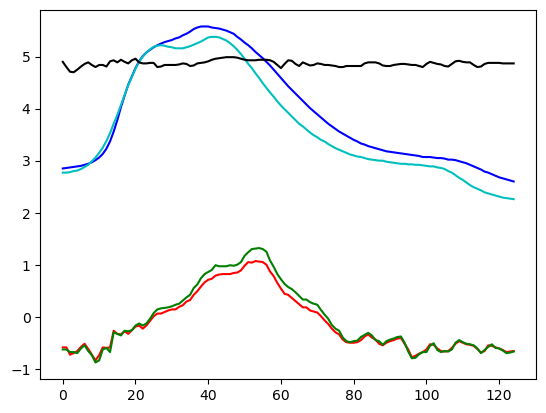

In [18]:
period_st = 60425
period_end = 60550

plt.plot(df['여의리(의령군)_수위'].values[period_st:period_end], color = 'r')
plt.plot(df['함안군(서출리)_수위'].values[period_st:period_end], color = 'b')
plt.plot(df['합천군(적포교)_수위'].values[period_st:period_end], color = 'g')
plt.plot(df['의령군(정암교)_수위'].values[period_st:period_end], color = 'c')

plt.plot(df_tgt['수위(EL.m)'].values[period_st:period_end], color = 'k') # 창녕함안보 수위

In [62]:
print(df['여의리(의령군)_수위'].values[period_st:period_end].argmax()) # 여의리와 합천군 수위가 가장 높아지는 시간과 창녕함안보의 수위가 가장 높아지는 시간의 차이(도달시간)
print(df['합천군(적포교)_수위'].values[period_st:period_end].argmax())
print(df_tgt.values[period_st:period_end].argmax())

14
14
17


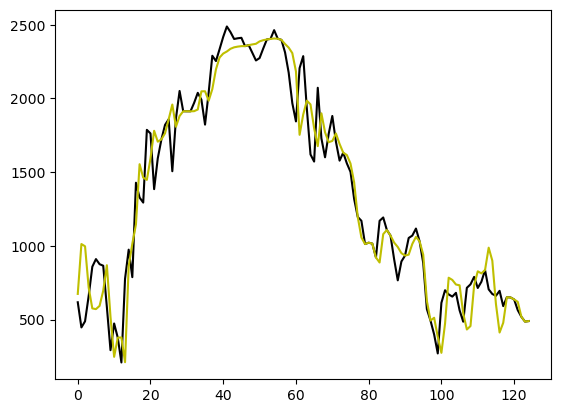

In [21]:
period_st = 60425
period_end = 60550

plt.plot(df_tgt['총유입량(㎥/s)'].values[period_st:period_end], color = 'k') # 창녕함안보 수위
plt.plot(df_tgt['총방류량(㎥/s)'].values[period_st:period_end], color = 'y') # 창녕함안보 수위

# plt.plot(df['길곡_강수량(mm)'].values[period_st:period_end], color = 'r')
# plt.plot(df['창녕_강수량(mm)'].values[period_st:period_end], color = 'b')
# plt.plot(df['청덕_강수량(mm)'].values[period_st:period_end], color = 'c')
# plt.plot(df['함안_강수량(mm)'].values[period_st:period_end], color = 'g')

# plt.plot(df_tgt.values[period_st:period_end], color = 'k') # 창녕함안보 수위


## Make Sliding Window

In [15]:
def make_sliding_window(data, lag): # data = dataframe, lag = window size

    data = data.drop(['Unnamed: 0'], axis = 1)
    sliding_lst = [data]

    for i in range(lag):
        sliding_lst.append(data.shift(i+1))
    

    sliding_df = pd.concat(sliding_lst, axis=1)
    
    return sliding_df

In [16]:
window_size = 0

sliding_df = make_sliding_window(df, window_size) # window = 12
# sliding_df = sliding_df.drop(['함안군(서출리)_수위', '합천군(적포교)_수위', '대병_강수량(mm)'], axis = 1)
sliding_df = sliding_df.astype('float')

In [17]:
sliding_df

,여의리(의령군)_수위,의령군(정암교)_수위,함안군(서출리)_수위,합천군(적포교)_수위,길곡_강수량(mm),대병_강수량(mm),창녕_강수량(mm),청덕_강수량(mm),함안_강수량(mm)
0,0.57,3.83,4.41,0.63,0.0,0.0,0.0,0.0,0.0
1,0.57,3.82,4.40,0.63,0.0,0.0,0.0,0.0,0.0
2,0.57,3.81,4.39,0.62,0.0,0.0,0.0,0.0,0.0
3,0.57,3.79,4.38,0.61,0.0,0.0,0.0,0.0,0.0
4,0.57,3.77,4.37,0.60,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
81930,10.09,0.17,1.82,4.36,0.0,0.0,0.0,0.0,0.0
81931,10.08,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0
81932,10.09,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0
81933,10.10,0.17,1.81,4.36,0.0,0.0,0.0,0.0,0.0


In [18]:
sliding_df.isnull().sum()

여의리(의령군)_수위    0
의령군(정암교)_수위    0
함안군(서출리)_수위    0
합천군(적포교)_수위    0
길곡_강수량(mm)     0
대병_강수량(mm)     0
창녕_강수량(mm)     0
청덕_강수량(mm)     0
함안_강수량(mm)     0
dtype: int64

In [19]:
sliding_df = sliding_df.truncate(before=window_size) # Nan 값이 있는 맨 앞 window_size개 데이터 자르기
df_tgt = df_tgt.truncate(before=window_size)

## Split Train / Test

In [20]:
# Train : 2012-08-27 XX:00:00 ~ 2020-01-01 00:00:00
# val   : 2019-01-01 01:00:00 ~ 2020-01-01 00:00:00
# Test  : 2020-01-01 01:00:00 ~ 2021-12-31 23:00:00

print(sliding_df.loc[64392]) # 2020-01-01 00:00:00 기준

여의리(의령군)_수위   -0.70
의령군(정암교)_수위    0.50
함안군(서출리)_수위    1.76
합천군(적포교)_수위    4.25
길곡_강수량(mm)     0.00
대병_강수량(mm)     0.00
창녕_강수량(mm)     0.00
청덕_강수량(mm)     0.00
함안_강수량(mm)     0.00
Name: 64392, dtype: float64


In [21]:
train_df = sliding_df.truncate(after=55631)
val_df = sliding_df.truncate(before=55632, after=64391)
test_df = sliding_df.truncate(before=64392)


train_label_df = df_tgt.truncate(after=55631)
val_label_df = df_tgt.truncate(before=55632, after=64391)
test_label_df = df_tgt.truncate(before=64392)

In [22]:
len(test_df)

17543

# Network Save/load

In [23]:
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)
    torch.save({'net' : net.state_dict(), 'optim' : optim.state_dict()}, 
    './%s/model_epoch%d.pth' % (ckpt_dir, epoch))

def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key = lambda f : int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('./%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

# Dataset

In [24]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, target):
    
        self.data = data
        self.target = target

        scaler = MinMaxScaler() # 스케일링
        self.data = pd.DataFrame(scaler.fit_transform(self.data)) 
        # self.target = pd.DataFrame(scaler.fit_transform(self.target))

        self.data = torch.tensor(self.data.values).float() # 텐서 변환
        self.target = torch.tensor(self.target.values).float()


    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):

        data = self.data[idx]
        target = self.target[idx]
        
        return data, target

In [25]:
train_dataset = Dataset(train_df, train_label_df)
val_dataset = Dataset(val_df, val_label_df)
test_dataset = Dataset(test_df, test_label_df)

In [26]:
train_label_df

0        5.45
1        5.45
2        5.45
3        5.45
4        5.45
         ... 
55627    4.84
55628    4.84
55629    4.84
55630    4.84
55631    4.83
Name: 수위(EL.m), Length: 55632, dtype: float64

In [27]:
test_label_df

64392    4.87
64393    4.87
64394    4.85
64395    4.85
64396    4.85
         ... 
81930    4.89
81931    4.89
81932    4.90
81933    4.90
81934    4.90
Name: 수위(EL.m), Length: 17543, dtype: float64

# Train / Val Function and Other Components

In [28]:
# Parameters
lr = 1e-3
batch_size = 128
num_epoch = 200

net = model.TDNN().to(device)
loss_fn = RMSELoss().to(device)
optim = torch.optim.Adam(net.parameters(), lr=lr)

ckpt_dir = './checkpoint'

In [29]:
def train(train_loader):
    net.train()
    train_loss_arr = []

    for batch_idx, (data, target) in enumerate(train_loader, start = 1):
        target = target.to(device)
        data = data.to(device)

        output = net(data)

        optim.zero_grad()
        loss = loss_fn(output, target)
        loss.backward()
        optim.step()
        train_loss_arr.append(loss.item())
    
    return np.mean(train_loss_arr)

def evaluate(test_loader):
    with torch.no_grad():
        net.eval()
        val_loss_arr = []
        output_lst = []

        
        for batch_idx, (data, target) in enumerate(test_loader, start = 1):
            target = target.to(device)
            data = data.to(device)
            

            output = net(data)

            save_output = output.cpu()            
            output_lst.append(save_output)

            loss = loss_fn(output, target)
            val_loss_arr.append(loss.item())

    return np.mean(val_loss_arr), output_lst

# Running

## Train

In [31]:
net, optim, st_epoch = load(ckpt_dir = ckpt_dir, net = net, optim = optim)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, num_workers = 8)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers= 8)

print('Start Epoch :', st_epoch)

train_loss_lst = []
val_loss_lst = []

for epoch in range(st_epoch + 1, num_epoch + 1):
    since = time.time()
    
    train_loss = train(train_loader = train_loader)
    train_loss_lst.append(train_loss)

    val_loss, output_lst = evaluate(test_loader=val_loader)
    val_loss_lst.append(val_loss)

    elapsed_time = time.time()-since
    print('EPOCH %04d / %04d | ELAPSED_TIME %.4f' %(epoch, num_epoch, elapsed_time))
    print('TRAIN_LOSS %.4f | VAL_LOSS %.4f' %(train_loss, val_loss))

    if epoch % 100 == 0:
        save(ckpt_dir = ckpt_dir, net = net, optim = optim, epoch = epoch)

Start Epoch : 0
EPOCH 0001 / 0200 | ELAPSED_TIME 1.9420
TRAIN_LOSS 6.0043 | VAL_LOSS 0.9280
EPOCH 0002 / 0200 | ELAPSED_TIME 1.9505
TRAIN_LOSS 2.2354 | VAL_LOSS 0.3296
EPOCH 0003 / 0200 | ELAPSED_TIME 1.9866
TRAIN_LOSS 2.1842 | VAL_LOSS 0.2632
EPOCH 0004 / 0200 | ELAPSED_TIME 1.9182
TRAIN_LOSS 2.1541 | VAL_LOSS 0.1773
EPOCH 0005 / 0200 | ELAPSED_TIME 1.9174
TRAIN_LOSS 2.1452 | VAL_LOSS 0.1692
EPOCH 0006 / 0200 | ELAPSED_TIME 2.0453
TRAIN_LOSS 2.1420 | VAL_LOSS 0.1624
EPOCH 0007 / 0200 | ELAPSED_TIME 1.8672
TRAIN_LOSS 2.1366 | VAL_LOSS 0.1559
EPOCH 0008 / 0200 | ELAPSED_TIME 1.8885
TRAIN_LOSS 2.1300 | VAL_LOSS 0.1495
EPOCH 0009 / 0200 | ELAPSED_TIME 1.8877
TRAIN_LOSS 2.1256 | VAL_LOSS 0.1430
EPOCH 0010 / 0200 | ELAPSED_TIME 1.9663
TRAIN_LOSS 2.1209 | VAL_LOSS 0.1380
EPOCH 0011 / 0200 | ELAPSED_TIME 1.8981
TRAIN_LOSS 2.1177 | VAL_LOSS 0.1347
EPOCH 0012 / 0200 | ELAPSED_TIME 1.9787
TRAIN_LOSS 2.1138 | VAL_LOSS 0.1290
EPOCH 0013 / 0200 | ELAPSED_TIME 1.9258
TRAIN_LOSS 2.1097 | VAL_LOSS 0.1

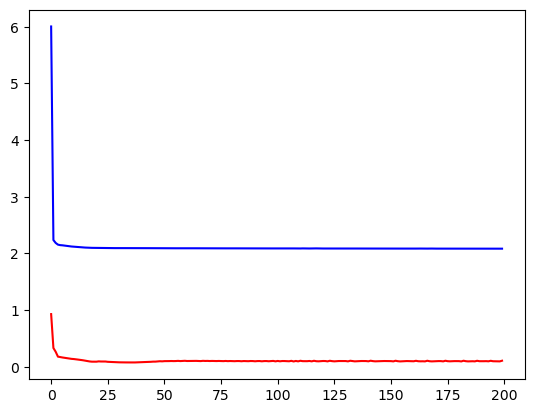

In [32]:
plt.plot(train_loss_lst, color = 'b')
plt.plot(val_loss_lst, color='r')

## Test

In [33]:
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False, num_workers= 8)
test_loss, output_lst = evaluate(test_loader)
print('Test Loss mean :', test_loss)

/home/khs1/miniconda3/envs/cw/lib/python3.8/site-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test Loss mean : 1.919825122172331


/home/khs1/miniconda3/envs/cw/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/khs1/miniconda3/envs/cw/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


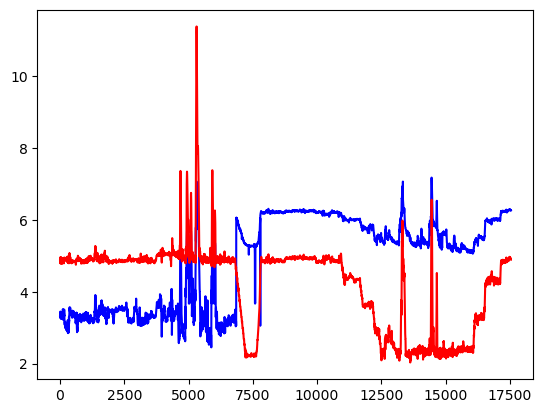

In [35]:
plt.plot(output_lst, color = 'b')
plt.plot(test_label_df.values, color = 'r')

In [ ]:
output_lst[9000]

In [ ]:
test_label_df.values[9000]

In [ ]:
plt.plot(output_lst, color = 'b')


In [ ]:
plt.plot(train_label_df)

# Reload model

In [ ]:
import importlib
importlib.reload(model)

In [ ]:
train_df